In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#### Pre processing img data 

In [6]:
train_dir = "Datasets/cifar-10-img/train"
test_dir = "Datasets/cifar-10-img/test"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# here batch_size is the number of images in each batch
train_batch_size = 5000
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=train_batch_size,
    class_mode='categorical'
)
test_batch_size = 1000
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=test_batch_size,
    class_mode='categorical'
)

Found 40079 images belonging to 10 classes.
Found 9921 images belonging to 10 classes.


#### Selecting only first batch with 5000 images as train and test data

In [7]:
x_train, y_train =  train_generator[0]
x_test, y_test = test_generator[0]

print(len(x_train))
print(len(x_test))

5000
1000


#### a. Load in a pre-trained CNN model trained on a large dataset

In [8]:
# Load VGG16 without top layers
weights_path = "Datasets/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3))

#### b. Freeze parameters (weights) in model’s lower convolutional layers

In [9]:
for layer in base_model.layers:
   layer.trainable = False

#### c. Add custom classifier with several layers of trainable parameters to model

In [10]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

#### d. Train classifier layers on training data available for task

In [11]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 8s 25ms/step - loss: 1.9804 - accuracy: 0.2870 - val_loss: 1.6177 - val_accuracy: 0.4480
Epoch 2/10
79/79 [==============================] - 1s 13ms/step - loss: 1.5928 - accuracy: 0.4342 - val_loss: 1.4361 - val_accuracy: 0.4820
Epoch 3/10
79/79 [==============================] - 1s 13ms/step - loss: 1.4683 - accuracy: 0.4744 - val_loss: 1.3534 - val_accuracy: 0.5010
Epoch 4/10
79/79 [==============================] - 1s 12ms/step - loss: 1.3546 - accuracy: 0.5226 - val_loss: 1.3088 - val_accuracy: 0.5340
Epoch 5/10
79/79 [==============================] - 1s 12ms/step - loss: 1.2987 - accuracy: 0.5472 - val_loss: 1.2667 - val_accuracy: 0.5370
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 1.2443 - accuracy: 0.5664 - val_loss: 1.2508 - val_accuracy: 0.5520
Epoch 7/10
79/79 [==============================] - 1s 13ms/step - loss: 1.1961 - accuracy: 0.5792 - val_loss: 1.2421 - val_accuracy: 0.5600
Epoch 8/10
79

#### e. Fine-tune hyper parameters and unfreeze more layers as needed

In [12]:
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3))
# freeze all layers first
for layer in base_model.layers:
   layer.trainable = False
# unfreeze last 4 layers of base model
for layer in base_model.layers[len(base_model.layers) - 4:]:
   layer.trainable = True
# fine-tuning hyper parameters
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# training fine tuned model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 3s 19ms/step - loss: 1.9629 - accuracy: 0.2448 - val_loss: 1.7465 - val_accuracy: 0.4210
Epoch 2/10
79/79 [==============================] - 1s 16ms/step - loss: 1.3539 - accuracy: 0.5102 - val_loss: 1.1587 - val_accuracy: 0.5800
Epoch 3/10
79/79 [==============================] - 1s 17ms/step - loss: 1.0823 - accuracy: 0.6266 - val_loss: 1.1635 - val_accuracy: 0.6060
Epoch 4/10
79/79 [==============================] - 1s 16ms/step - loss: 0.9447 - accuracy: 0.6854 - val_loss: 1.1963 - val_accuracy: 0.5960
Epoch 5/10
79/79 [==============================] - 1s 16ms/step - loss: 0.8191 - accuracy: 0.7270 - val_loss: 1.0476 - val_accuracy: 0.6500
Epoch 6/10
79/79 [==============================] - 1s 15ms/step - loss: 0.6763 - accuracy: 0.7752 - val_loss: 1.1138 - val_accuracy: 0.6400
Epoch 7/10
79/79 [==============================] - 1s 15ms/step - loss: 0.6204 - accuracy: 0.7950 - val_loss: 1.2926 - val_accuracy: 0.6180
Epoch 8/10
79

In [13]:
import matplotlib.pyplot as plt
predicted_value = model.predict(x_test)

32/32 [==============================] - 1s 6ms/step


In [14]:
labels = list(test_generator.class_indices.keys())

Preditcted:  bird
Actual:  deer


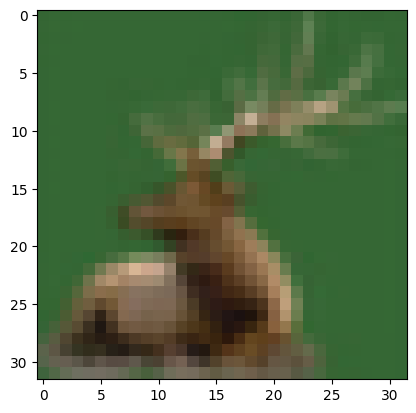

In [15]:
n = 890
plt.imshow(x_test[n])
print("Preditcted: ",labels[np.argmax(predicted_value[n])])
print("Actual: ", labels[np.argmax(y_test[n])])